In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,DotProduct
import pandas as pd
import torch

In [2]:
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels
from snorkel.learning.pytorch import LSTM
from scipy import vstack

In [3]:
lstm_h = LSTM(n_threads=None)
lstm_h.load('hand_labeled_small')

[LSTM] Loaded model <hand_labeled_small>


In [4]:
lstm_l = LSTM(n_threads=None)
lstm_l.load('weak_supervision')

[LSTM] Loaded model <weak_supervision>


In [5]:
session = SnorkelSession()

In [98]:
ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

train = session.query(ChemicalDisease).filter(ChemicalDisease.split == 0).all()
dev = session.query(ChemicalDisease).filter(ChemicalDisease.split == 1).all()
test = session.query(ChemicalDisease).filter(ChemicalDisease.split == 2).all()

In [7]:
len(test)

4683

In [8]:
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [9]:
from snorkel.annotations import load_marginals
train_marginals = load_marginals(session, split=0)

In [99]:
dev.extend(train[:1000])
combined = vstack((L_gold_dev.toarray(), L_gold_train[:1000].toarray()))
combined[combined == -1] = 0
y = np.append(1-combined, combined,axis=1)

In [107]:
from snorkel.models import Candidate
features_small = lstm_l.feature_outputs(dev,1920)

In [101]:
kernel =  RBF(1) + WhiteKernel(noise_level=.1) #first attempt at defining a kernel. Not exactly sure what will be best for this or how to tell
gpc_high = GaussianProcessClassifier(kernel = kernel)

In [108]:
features_small.shape

torch.Size([192000])

In [109]:
features_small = features_small.reshape(1920,100)


In [110]:
gpc_high.fit(features_small.detach().numpy(),combined.reshape(1920,))

GaussianProcessClassifier(copy_X_train=True,
                          kernel=RBF(length_scale=1) + WhiteKernel(noise_level=0.1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

In [114]:
test_features = lstm_l.feature_outputs(test,100).reshape(4683,100)

In [17]:
uncertainty = []

In [115]:
pred = gpc_high.predict(test_features.detach().numpy())

In [116]:
test_y = L_gold_test.toarray()
test_y[test_y==-1] = 0

In [117]:
fp, tp, fn, tn = 0,0,0,0
for e,x in enumerate(test_y):
    if x==1 and pred[e]==1:
        tp += 1
    elif x==1 and pred[e]==0:
        fn += 1
    elif x==0 and pred[e]==1:
        fp +=1
    elif x==0 and pred[e]==0:
        tn +=1
p = tp / (tp + fp)
r = tp / (tp + fn)
print(2 / (1/p + 1/r))

0.15568240788790866


In [118]:
gpc_high.kernel_

RBF(length_scale=0.937) + WhiteKernel(noise_level=1e-05)

In [21]:
# ok so next step, train a gpc for both the high fidelity (1920 datapoints) and low fidelity (the rest of the train set)
# then, create a new model that makes predictions based on both of these, and uses the one with lower uncertainty to make a prediciton
# see which one has the better F1 score, and ideally we can beat at least the snorkel model, and even better would be wonderful
# if we beat the hand labeled model

In [22]:
kernel2 = RBF(1,length_scale_bounds =[.1,1]) + WhiteKernel(noise_level=8.18e-05, noise_level_bounds = [8.18e-05,8.18e-05])
gpc_low = GaussianProcessClassifier(kernel = kernel2)

In [23]:
gpc_high.kernel_

RBF(length_scale=4.84) + WhiteKernel(noise_level=8.18e-05)

In [120]:
x = train[1000:]
low_train_y = train_marginals[1000:]
low_train_y[low_train_y <.5 ] = 0
low_train_y[low_train_y >=.5] = 1
#y = np.append(1-low_train_y, low_train_y,axis=1)

In [121]:
features_large = lstm_l.feature_outputs(x,100)

In [129]:
cov = np.matmul(features_large.detach().numpy().transpose() , features_large.detach().numpy())

In [139]:
s = np.linalg.svd(cov)
s = s[2]

In [140]:
s

array([[ -2.23308325e-01,   1.33821160e-01,   1.30315097e-02, ...,
         -7.67141022e-03,   1.35805503e-01,  -4.49314900e-03],
       [ -2.55532920e-01,   1.54999912e-01,   3.18487659e-02, ...,
          2.17907168e-02,  -2.59740174e-01,  -7.03165354e-03],
       [ -6.29722849e-02,  -6.89468160e-02,   4.27895673e-02, ...,
          1.89673193e-02,   3.77352126e-02,   2.99257832e-03],
       ..., 
       [  7.44430217e-05,  -1.49986823e-03,  -1.54076032e-02, ...,
          6.51995977e-03,   1.40662678e-03,  -7.69380573e-03],
       [  7.80556584e-05,  -9.12342512e-04,   1.62718520e-02, ...,
          1.18965760e-03,  -1.85143366e-03,  -5.29571809e-03],
       [  2.11892169e-04,   6.03222114e-04,   1.15504852e-02, ...,
         -6.08208706e-04,   1.26374571e-03,   3.16347694e-03]], dtype=float32)

In [122]:
features_large = features_large.reshape(7433,100)

In [123]:
gpc_low.fit(features_large.detach().numpy(), low_train_y.reshape(7433,))

GaussianProcessClassifier(copy_X_train=True,
                          kernel=RBF(length_scale=1) + WhiteKernel(noise_level=8.18e-05),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

In [28]:
gpc_low.kernel_

RBF(length_scale=1) + WhiteKernel(noise_level=8.18e-05)

In [29]:
q = []
l = gpc_high.predict_proba(features_small.detach().numpy(), uncertainty = q)
q = q[0]

In [30]:
un = []

In [31]:
gpc_low.predict_proba(features_large.detach().numpy(), uncertainty = un)

array([[ 0.30936607,  0.69063393],
       [ 0.34940898,  0.65059102],
       [ 0.35583175,  0.64416825],
       ..., 
       [ 0.39510062,  0.60489938],
       [ 0.23210697,  0.76789303],
       [ 0.37409694,  0.62590306]])

In [32]:
un = np.array(un[0])

In [33]:
un.mean()

0.39252454338954762

In [55]:
pred_low = gpc_low.predict(test_features_low.detach().numpy())

In [56]:
pred_high = gpc_high.predict(test_features.detach().numpy())

In [35]:
pred_low.min()

0.0

In [36]:
test_features_low = lstm_l.feature_outputs(test,100).reshape(4683,100)

In [53]:
fp, tp, fn, tn = 0,0,0,0
for e,x in enumerate(test_y):
    if x==1 and preds[e]==1:
        tp += 1
    elif x==1 and preds[e]==0:
        fn += 1
    elif x==0 and preds[e]==1:
        fp +=1
    elif x==0 and preds[e]==0:
        tn +=1
p = tp / (tp + fp)
r = tp / (tp + fn)
print(2 / (1/p + 1/r))

0.4676022693341296


In [71]:
buckets = np.linspace(0,1.3, 20)

In [91]:
f1scores = []

for i in range(buckets.size -1):
    count = 0
    tp,fp,tn,fn = 0,0,0,0
    for j,p in enumerate(test_y):
        if uh[j] >= buckets[i] and uh[j] < buckets[i+1]:
            count += 1
            if p == 0 and pred_high[j] == 0:
                tn += 1
            elif p == 0 and pred_high[j] == 1:
                fp += 1
            elif p == 1 and pred_high[j] == 0:
                fn += 1
            else: #p == 1 and preds[j] == 1:
                tp += 1
    try:
        p = tp / (tp + fp)
    except:
        p = 0
    try:
        r = tp / (tp + fn)
    except: 
        r = 0
    try:
        f1 = 2/(1/p + 1/r)
    except:
        f1 = 0
    f1scores.append(f1)
    print ("Bucket {}: \n Count: {}\n F1: {}\n{},{},{},{}".format(buckets[i+1], count, f1,tp,fp,tn,fn))

Bucket 0.06842105263157895: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 0.1368421052631579: 
 Count: 12
 F1: 0.4444444444444444
2,3,5,2
Bucket 0.20526315789473687: 
 Count: 798
 F1: 0.30158730158730157
38,35,584,141
Bucket 0.2736842105263158: 
 Count: 1739
 F1: 0.4856879039704524
263,281,919,276
Bucket 0.34210526315789475: 
 Count: 1351
 F1: 0.5178743961352656
268,275,584,224
Bucket 0.41052631578947374: 
 Count: 599
 F1: 0.4291845493562232
100,141,233,125
Bucket 0.4789473684210527: 
 Count: 128
 F1: 0.39534883720930236
17,12,59,40
Bucket 0.5473684210526316: 
 Count: 42
 F1: 0.3846153846153846
5,5,21,11
Bucket 0.6157894736842106: 
 Count: 13
 F1: 1.0
2,0,11,0
Bucket 0.6842105263157895: 
 Count: 1
 F1: 0
0,1,0,0
Bucket 0.7526315789473684: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 0.8210526315789475: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 0.8894736842105264: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 0.9578947368421054: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 1.0263157894736843: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 1.0947368421052632:

In [92]:
f1scores = np.array(f1scores)

In [93]:
buckets[1:]

array([ 0.06842105,  0.13684211,  0.20526316,  0.27368421,  0.34210526,
        0.41052632,  0.47894737,  0.54736842,  0.61578947,  0.68421053,
        0.75263158,  0.82105263,  0.88947368,  0.95789474,  1.02631579,
        1.09473684,  1.16315789,  1.23157895,  1.3       ])

<BarContainer object of 19 artists>

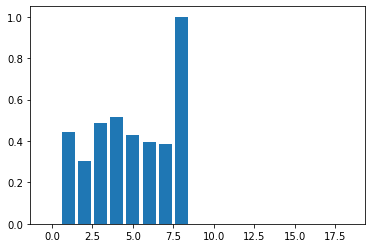

In [94]:
plt.bar(np.arange(19),f1scores)


In [268]:
print (p,r)

0.3217332734620566 0.9464993394980185


In [267]:
print (fp, tp, fn, tn)

3021 1433 81 148


In [52]:
preds = []
for i in pred_multi:
    if i[0] >= .5:
        preds.append(0)
    else:
        preds.append(1)

In [49]:
c = 0
def predict_multi(features_h, features_l):
    c = 0
    uh = []
    ul = []
    ph = gpc_high.predict_proba(features_h, uncertainty = uh)
    pl = gpc_low.predict_proba(features_l, uncertainty = ul)
    ul = np.array(ul[0])
    uh = np.array(uh[0])
    #ul /= ul.mean()
    #uh /= uh.mean()
    res = []
    for i in range(len(ph)):
        if uh[i] < ul[i]:
            res.append(ph[i])
        else:
            c += 1
            res.append(pl[i])
    return res, ul, uh,c

In [50]:
pred_multi,ul,uh,c = predict_multi(test_features.detach().numpy(),test_features_low.detach().numpy())

In [51]:
print (ul.mean(), uh.mean())

0.519958176437 0.273798980653


In [154]:
gpc_low.kernel_

RBF(length_scale=4.84) + WhiteKernel(noise_level=8.18e-05)

In [157]:
ul = np.array(ul)
uh = np.array(uh)
print (ul.shape, ul.mean(), uh.mean())

(4683,) 0.505423555155 0.273798980653


In [162]:
c

2520

In [72]:
ul_train = []
gpc_low.predict_proba(test_features.detach().numpy(), uncertainty = ul_train)

array([[ 0.49925432,  0.50074568],
       [ 0.41321913,  0.58678087],
       [ 0.46745588,  0.53254412],
       ..., 
       [ 0.5377594 ,  0.4622406 ],
       [ 0.45638348,  0.54361652],
       [ 0.59356109,  0.40643891]])

In [73]:
ul_train = np.array(ul_train)
ul_train.min()

1.4319304127654084

In [75]:
gpc_low.kernel_

DotProduct(sigma_0=0.629) + WhiteKernel(noise_level=0.0356)

In [94]:
prob_multi = pred_multi
pred_multi = []
for x in prob_multi:
    if x[0] > .5:
        pred_multi.append(0)
    else:
        pred_multi.append(1)

In [41]:
pred_multi

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [48]:
fp, tp, fn, tn = 0,0,0,0
for e,x in enumerate(test_y):
    if x==1 and pred_multi[e]==1:
        tp += 1
    elif x==1 and pred_multi[e]==0:
        fn += 1
    elif x==0 and pred_multi[e]==1:
        fp +=1
    elif x==0 and pred_multi[e]==0:
        tn +=1
p = tp / (tp + fp)
r = tp / (tp + fn)
print(2 / (1/p + 1/r))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [47]:
uh

[array([ 0.33682608,  0.32045873,  0.26405045, ...,  0.25729349,
         0.21182223,  0.25401706])]

In [48]:
ul

[array([ 1.00001,  1.00001,  1.00001, ...,  1.00001,  1.00001,  1.00001])]

In [49]:
features_large.detach().numpy()[:2000]

array([[  9.59702492e-01,  -2.07846183e-02,  -1.17311694e-01, ...,
         -2.46625650e-03,   1.67484596e-10,  -3.84214109e-05],
       [ -8.29112902e-03,  -1.40086794e-02,  -1.56942697e-05, ...,
         -1.21911453e-05,   6.36399448e-01,   2.56081312e-09],
       [ -3.95614728e-02,   8.69552823e-05,  -2.61835448e-05, ...,
         -3.06349443e-06,   7.43018985e-01,   1.17367854e-07],
       ..., 
       [  9.63983417e-01,  -2.62822419e-01,  -2.57440988e-05, ...,
         -7.91611171e-07,   3.50048794e-07,   2.46662626e-06],
       [  9.75530505e-01,  -6.72372818e-01,  -3.59097077e-03, ...,
         -3.20851768e-06,   1.78752000e-08,   1.22803950e-03],
       [  5.81623614e-01,   4.32778895e-01,  -1.84212957e-04, ...,
         -2.65563340e-08,   6.51431968e-04,   3.38046555e-03]], dtype=float32)

In [51]:
sum(low_train_y.reshape(7433,)[:2000])

701

In [52]:
features_small.detach().numpy()

array([[ -8.55939090e-01,   5.15784677e-08,   4.09696877e-05, ...,
          5.54602444e-02,  -9.22462263e-04,   3.37288119e-02],
       [  2.35044971e-01,  -5.28448284e-01,   9.33671072e-02, ...,
         -6.68086708e-01,   2.75011361e-01,  -3.23511660e-03],
       [ -9.99716043e-01,   5.55167929e-08,   2.33703286e-05, ...,
          1.52055383e-01,  -1.11736618e-02,   3.03702801e-02],
       ..., 
       [  3.35348338e-01,  -7.60109186e-01,   8.92941773e-01, ...,
         -1.06721291e-06,  -7.43226707e-02,   2.81780269e-02],
       [  6.74467683e-01,  -8.22979748e-01,   9.49120045e-01, ...,
         -5.42428374e-01,  -5.02795279e-01,  -6.65749237e-02],
       [  7.60913432e-01,  -7.61401474e-01,   3.95959496e-01, ...,
         -6.79969673e-07,   6.77862298e-03,  -8.65873822e-04]], dtype=float32)

In [53]:
combined.reshape(1920,)

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [54]:
low_train_y.reshape(7433,)[:2000]

array([0, 1, 1, ..., 0, 0, 0])

In [55]:
gpc_high.score(features_small.detach().numpy(),combined.reshape(1920,))

0.93958333333333333

In [56]:
gpc_low.score(features_large.detach().numpy()[:2000], low_train_y.reshape(7433,)[:2000])

0.83999999999999997

In [70]:
u = []

In [96]:
gpc_low.predict_proba(features_large.detach().numpy(), uncertainty = u)

array([[ 0.71464359,  0.28535641],
       [ 0.49435244,  0.50564756],
       [ 0.48459987,  0.51540013],
       ..., 
       [ 0.77893781,  0.22106219],
       [ 0.65645597,  0.34354403],
       [ 0.78134485,  0.21865515]])

In [99]:
len(u[0])

7433

In [146]:
a = []
h = gpc_high.predict_proba(test_features.detach().numpy(), uncertainty = a)

In [152]:
a[0].mean()

0.27379898065277769

In [78]:
gpc_high.kernel_

RBF(length_scale=4.84) + WhiteKernel(noise_level=8.18e-05)

In [106]:
gpc_low.kernel_

RBF(length_scale=0.774) + RBF(length_scale=1.51) + WhiteKernel(noise_level=1e-05)

In [127]:
out = lstm_l.marginals(test)

In [168]:
comb = []
for e,p in enumerate(h):
    if a[0][e] < .35:
        comb.append(p[1])
    else:
        comb.append(out[e])

In [169]:
c = np.array(comb)
c[c < .5] = 0
c[c!=0] = 1

In [170]:
fp, tp, fn, tn = 0,0,0,0
for e,x in enumerate(test_y):
    if x==1 and c[e]==1:
        tp += 1
    elif x==1 and c[e]==0:
        fn += 1
    elif x==0 and c[e]==1:
        fp +=1
    elif x==0 and c[e]==0:
        tn +=1
p = tp / (tp + fp)
r = tp / (tp + fn)
print(2 / (1/p + 1/r))

0.47920665387076133


In [142]:
ph = []
for i in h:
    if i[0] > .5:
        ph.append(0)
    else:
        ph.append(1)

In [144]:
x[0]

0

In [ ]:
# histogram of prediction accuracy by uncertainty, should really do this on the train set rather than test set